### Problem Statement
The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process. 

In [740]:

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [741]:
train_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_LZdllcl.csv'
test_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/test_2umaH9m.csv'
train_result='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_result.csv'

In [742]:
train=pd.read_csv(train_data)
test=pd.read_csv(test_data)
test_results = pd.read_csv(train_result)

In [743]:
target = 'is_promoted'
IDcol = 'employee_id'
exclusion=['education_Below Secondary','region_region_10','region_region_21','region_region_12','region_region_19','region_region_6','region_region_14','region_region_33','region_region_3']

In [744]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(54808, 15) (23490, 14) (78298, 15)


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


def f_trans(col1,col2): 
    if(col1 in (5.0,4.0,3.0) and col2==1):
        return 1 
    else: 
        return 0

data['top_performer'] = data.apply(lambda x: f_trans(x['previous_year_rating'],x['KPIs_met >80%']), axis=1)

def age_trans(age):
    if(age<30):
        return 'Young'
    elif(age>=30 and age<40):
        return 'Middle Age'
    elif(age >=40):
        return 'Senior'

data['age']=data['age'].apply(age_trans)

In [745]:
def rating_trans(rating): 
    if(rating>=4.0): 
        return 'High' 
    elif(rating==3.0): 
        return 'Medium' 
    elif(rating < 3.0): 
        return 'low'

In [746]:
data['previous_year_rating']=data['previous_year_rating'].apply(rating_trans)

In [747]:
data.previous_year_rating[data.previous_year_rating.isnull()]=3.0

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [748]:
data.education[data.education.isnull()]="Bachelor's"

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [749]:
data=pd.get_dummies(data,columns=['department','education','gender','recruitment_channel','region','previous_year_rating'])

In [750]:
#data.drop(exclusion,axis=1,inplace=True)

In [751]:
train=data[data.source=='train']
train.drop('source',axis=1,inplace=True)
test=data[data.source=='test']
test.drop(['source','is_promoted'],axis=1,inplace=True)

C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [752]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(train, test_size=0.0001)

In [753]:
testset.head()

,KPIs_met >80%,age,avg_training_score,awards_won?,employee_id,is_promoted,length_of_service,no_of_trainings,department_Analytics,department_Finance,...,region_region_4,region_region_5,region_region_6,region_region_7,region_region_8,region_region_9,previous_year_rating_3.0,previous_year_rating_High,previous_year_rating_Medium,previous_year_rating_low
9956,0,34,50,0,41870,0.0,3,2,0,0,...,0,0,0,0,0,0,0,0,1,0
13378,0,34,47,0,71373,0.0,10,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2148,0,34,49,0,14745,0.0,2,2,0,0,...,0,0,0,0,0,0,0,1,0,0
45751,0,39,69,0,36046,1.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1
51389,0,54,50,0,54596,0.0,25,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [754]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['employee_id','predprob']], on='employee_id')
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(results['is_promoted'], results['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

C:\Amrendra\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9437
AUC Score (Train): 0.929913
AUC Score (Test): 1.000000


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


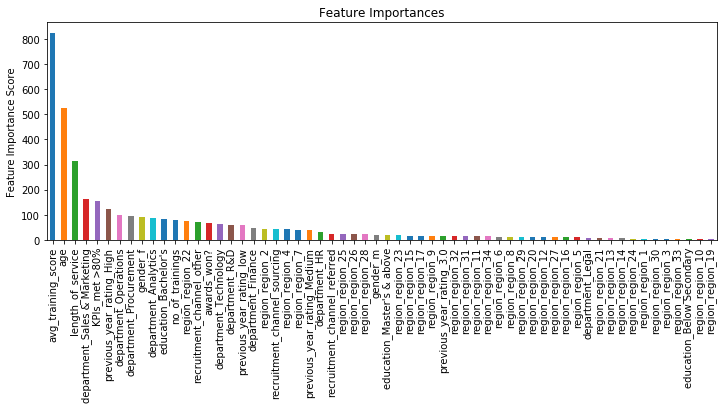

In [755]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=5,
        min_child_weight=4,
        reg_alpha=1,
        gamma=0,
        subsample=0.85,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, trainset, testset, predictors)

In [756]:
pred=xgb1.predict(test[predictors])

C:\Amrendra\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [757]:
s=pd.Series(pred.tolist()).astype(int)

In [684]:
s.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/s19.csv')

In [758]:
s.value_counts()

0    22796
1      694
dtype: int64

In [674]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=5,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [675]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.90981, std: 0.00358, params: {'reg_alpha': 1e-05},
  mean: 0.91005, std: 0.00367, params: {'reg_alpha': 0.01},
  mean: 0.91003, std: 0.00324, params: {'reg_alpha': 0.1},
  mean: 0.91017, std: 0.00351, params: {'reg_alpha': 1},
  mean: 0.88015, std: 0.00427, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.9101682775736858)

In [676]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [677]:

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.90894, std: 0.00474, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.90934, std: 0.00434, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.90920, std: 0.00406, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.90877, std: 0.00473, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.90869, std: 0.00406, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.90958, std: 0.00362, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.90927, std: 0.00418, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.90928, std: 0.00378, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.90973, std: 0.00384, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.85, 'subsample': 0.85},
 0.9097338205907823)

In [678]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6,8],
    'min_child_weight':[4,5,6,8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6, 8], 'min_child_weight': [4, 5, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [679]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.91006, std: 0.00388, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.91013, std: 0.00384, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.90936, std: 0.00385, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.90827, std: 0.00446, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: 0.91111, std: 0.00367, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.91048, std: 0.00444, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.91073, std: 0.00351, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.90965, std: 0.00408, params: {'max_depth': 5, 'min_child_weight': 8},
  mean: 0.90976, std: 0.00319, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.91000, std: 0.00276, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.90966, std: 0.00399, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: 0.90911, std: 0.00329, params: {'max_depth': 6, 'min_child_weight': 8},
  mean: 0.90766, std: 0.00330, params: {

In [680]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 54808 to 78297
Data columns (total 59 columns):
KPIs_met >80%                   23490 non-null int64
age                             23490 non-null int64
avg_training_score              23490 non-null int64
awards_won?                     23490 non-null int64
employee_id                     23490 non-null int64
length_of_service               23490 non-null int64
no_of_trainings                 23490 non-null int64
previous_year_rating            23490 non-null float64
department_Analytics            23490 non-null uint8
department_Finance              23490 non-null uint8
department_HR                   23490 non-null uint8
department_Legal                23490 non-null uint8
department_Operations           23490 non-null uint8
department_Procurement          23490 non-null uint8
department_R&D                  23490 non-null uint8
department_Sales & Marketing    23490 non-null uint8
department_Technology           23490